<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Pablo Badilla y Ignacio Meza D.
- Auxiliar: Sebastián Tinoco
- Ayudante: Felipe Arias y Diego Cortez

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Sebastián Versluys
- Nombre de alumno 2: Josué Guillen


### **Link de repositorio de GitHub:** `https://github.com/Nietsabas/MDS7202`

### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [1]:
!pip install pandas-profiling

You should consider upgrading via the 'C:\Users\jos_5\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install xgboost

You should consider upgrading via the 'C:\Users\jos_5\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from xgboost import XGBClassifier, plot_importance
from sklearn.inspection import permutation_importance

df = pd.read_csv('diabetes_data.csv')
df.head(4)

c:\Users\jos_5\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\jos_5\AppData\Local\Programs\Python\Python310\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
c:\Users\jos_5\AppData\Local\Programs\Python\Python310\lib\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


In [4]:
profile = pandas_profiling.ProfileReport(df)
profile.to_file("informe.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


## 2. Clasificación de pacientes con diabetes (0.5 pt)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo una buena elección de las features?.

In [5]:
# Cargar el dataset
data = pd.read_csv('diabetes_data.csv')

# Dividir los datos en características y objetivo
X = data.drop('Diabetes', axis=1)
X.columns = X.columns.astype(str)
y = data['Diabetes']

# Definir las columnas numéricas y categóricas
std_features = ['Age', 'BMI', 'GenHlth']
minmax_features = ['MentHlth', 'PhysHlth']

# Definir las transformaciones para las características numéricas
transformadores = [
    ('escala_minmax', MinMaxScaler(), minmax_features),
    ('escala_estandar', StandardScaler(), std_features)
]
# Combinar las transformaciones
preprocessor = ColumnTransformer(transformadores)

# Definir el modelo de XGBoost
model = XGBClassifier()

# Crear el pipeline con preprocesamiento y modelo
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)


# Obtener el informe de clasificación
print("Pipeline 1:")
print(classification_report(y_test, y_pred))


Pipeline 1:
              precision    recall  f1-score   support

         0.0       0.75      0.69      0.72      7090
         1.0       0.71      0.78      0.74      7049

    accuracy                           0.73     14139
   macro avg       0.73      0.73      0.73     14139
weighted avg       0.73      0.73      0.73     14139



Este primer modelo desarrollado para predecir la diabetes muestra resultados aceptables en términos de métricas de evaluación.

Precisión: El modelo tiene una precisión del 71% para las personas con diabetes y del 75% para las personas sin diabetes. Esto significa que de todas las predicciones clasificadas como diabetes o no diabetes, el modelo acierta en aproximadamente el 71% y el 75% respectivamente.

Recall: El recall es del 78% para las personas con diabetes y del 69% para las personas sin diabetes. Esto indica que el modelo logra identificar correctamente alrededor del 78% de las personas con diabetes y alrededor del 69% de las personas sin diabetes en el conjunto de prueba.

F1-score: El f1-score, que combina la precisión y el recall, es del 74% para las personas con diabetes y del 72% para las personas sin diabetes. Estas métricas reflejan un buen equilibrio entre la precisión y la capacidad del modelo para identificar correctamente las clases.

Accuracy: El accuracy general del modelo en el conjunto de prueba es del 73%. Esto significa que el 73% de las predicciones del modelo coinciden con las etiquetas reales de diabetes o no diabetes.

1. ¿Es acaso un buen predictor de diabetes?
Basándonos en las métricas proporcionadas, el modelo muestra una precisión del 71% para las personas con diabetes y del 75% para las personas sin diabetes. Además, el recall es del 78% para las personas con diabetes y del 69% para las personas sin diabetes. Estas métricas indican que el modelo tiene una capacidad razonable para clasificar correctamente a las personas en las categorías de diabetes y no diabetes.

2. ¿Qué buscan explicar las métricas utilizadas?
Las métricas utilizadas (precisión, recall, f1-score y accuracy) buscan evaluar diferentes aspectos del rendimiento del modelo de predicción de la diabetes. La precisión mide la proporción de predicciones positivas correctas en relación con el total de predicciones positivas. El recall, por su parte, indica la proporción de casos positivos que el modelo logra identificar correctamente. El f1-score combina la precisión y el recall para proporcionar una medida de equilibrio. El accuracy representa la proporción de todas las predicciones del modelo que coinciden con las etiquetas reales.

3. ¿Las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo es una buena elección de las features?
Las métricas utilizadas (precisión, recall, f1-score y accuracy) evalúan la capacidad de predicción global del modelo, pero no garantizan por sí solas que las características utilizadas sean la elección adecuada. Para asegurar la idoneidad de las características, es necesario realizar un análisis exploratorio de datos, pruebas de significancia estadística, técnicas de selección de características y validación cruzada. Estas técnicas permiten evaluar la relevancia y la importancia de las características en el modelo. Por lo tanto, las métricas no son suficientes para determinar la calidad de la elección de características, se requiere un enfoque adicional para validar su adecuación.

## 3. Importancia de las features con XGBoost (0.5 pt)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

In [6]:
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')
import matplotlib.pyplot as plt
import xgboost as xgb


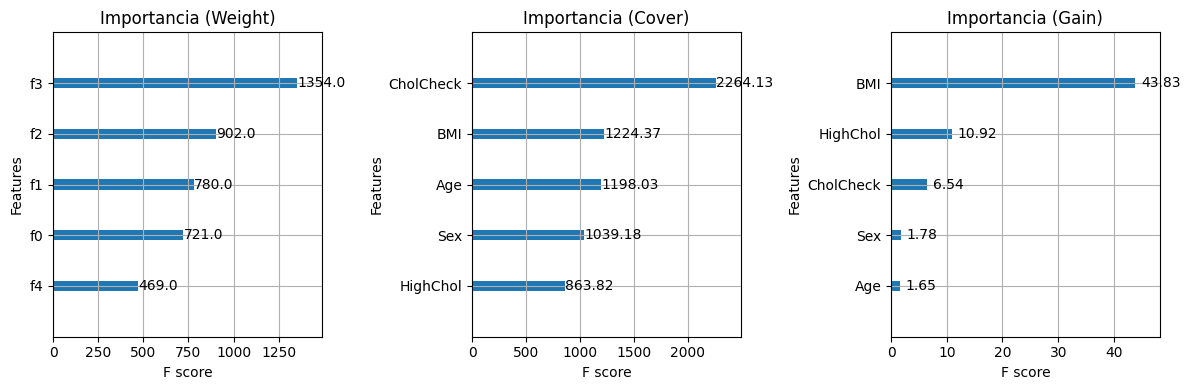

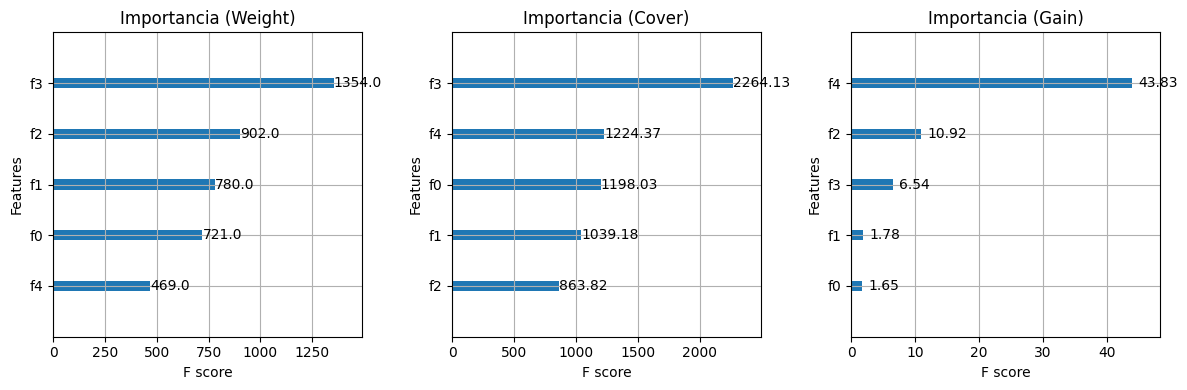

In [7]:
# Obtener los nombres de las columnas
column_names = X.columns

# Obtener la importancia de las características
feature_importance_weight = model.feature_importances_
feature_importance_cover = model.get_booster().get_score(importance_type='cover')
feature_importance_gain = model.get_booster().get_score(importance_type='gain')


# Redondear los valores de cover y gain
rounded_cover = {column_names[int(key[1:])]: np.round(val, 2) for key, val in feature_importance_cover.items()}
rounded_gain = {column_names[int(key[1:])]: np.round(val, 2) for key, val in feature_importance_gain.items()}

# Crear una figura y los subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot de la importancia basada en weight
plot_importance(model, importance_type='weight', ax=axs[0])
axs[0].set_title('Importancia (Weight)')

# Plot de la importancia basada en cover
plot_importance(rounded_cover, ax=axs[1])
axs[1].set_title('Importancia (Cover)')

# Plot de la importancia basada en gain
plot_importance(rounded_gain, ax=axs[2])
axs[2].set_title('Importancia (Gain)')

# Ajustar los subplots para una mejor visualización
plt.tight_layout()
plt.show()

# Redondear los valores de cover y gain
rounded_cover = {key: np.round(val, 2) for key, val in feature_importance_cover.items()}
rounded_gain = {key: np.round(val, 2) for key, val in feature_importance_gain.items()}

# Crear una figura y los subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot de la importancia basada en weight
plot_importance(model, importance_type='weight', ax=axs[0])
axs[0].set_title('Importancia (Weight)')

# Plot de la importancia basada en cover
plot_importance(rounded_cover, ax=axs[1])
axs[1].set_title('Importancia (Cover)')

# Plot de la importancia basada en gain
plot_importance(rounded_gain, ax=axs[2])
axs[2].set_title('Importancia (Gain)')

# Ajustar los subplots para una mejor visualización
plt.tight_layout()
plt.show()

**Respuesta:**

Se puede notar que los resultados de los distintos métodos toman en consideración en su top las mismas variables, pero les otorgan distintos niveles de importancia. Esto se debe a las apariciones en los diferentes niveles de los arboles generados. Si una variable tiene una mayor variedad de de valores posibles, donde esto afecta directamente a los pesos.

Junto a lo anterior un problema que presenta el método, radica en las correlacioens que existen entre los datos. Esto puede llevar a sesgos, ya que se les dan importancia a las características más correlacionadas, no entregando mayor información, mientran que otras que si entregan información adicional son subestimadas. Por lo que las interpretaciones no serían suficientes.

Por lo tanto, para obtener una interpretación más sólida y completa de un modelo basado en árboles, es recomendable complementar el análisis de importancia de características con otras técnicas, como el análisis de permuted feature importance o el análisis de partial dependence plots, que pueden ayudar a comprender mejor las relaciones entre las variables y su efecto en las predicciones del modelo.

En resúmen, la igualdad o desigualdad en los resultados se debe a las características inherentes de cada método de evaluación de importancia. Por ejemplo, el método basado en "weight" puede dar más peso a las características utilizadas en los niveles superiores del árbol, mientras que el método basado en "gain" puede resaltar las características que generan una mayor reducción de la impureza en cada división. Por lo tanto, las diferencias en los resultados se deben a las diferentes perspectivas desde las cuales se evalúa la importancia de las características.

Aunque las importancias obtenidas son una medida útil para obtener cierta interpretabilidad de un modelo basado en árboles, no explican completamente cómo cada característica influye en las predicciones. No ofrecen detalles sobre la dirección o la naturaleza de la relación entre características y resultados. Además, no capturan las interacciones complejas entre características. Por lo tanto, se pueden utilizar técnicas adicionales como el análisis de interacciones o la importancia de características permutadas para abordar estas limitaciones.

## 4. Métodos Agnósticos Globales (1 pt)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

In [8]:

res_pi = permutation_importance(pipeline, X_train, y_train, n_repeats= 30 , n_jobs= 2 ,
                                scoring= 'neg_mean_squared_error' , random_state= 42 )
res_pi

{'importances_mean': array([0.06866185, 0.        , 0.        , 0.        , 0.0706358 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.10296477, 0.01028357, 0.01439004, 0.        ,
        0.        , 0.        ]),
 'importances_std': array([0.00143286, 0.        , 0.        , 0.        , 0.00101413,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00147347, 0.00061742, 0.000672  , 0.        ,
        0.        , 0.        ]),
 'importances': array([[0.06862589, 0.07027037, 0.07018195, 0.0705356 , 0.06813078,
         0.06551377, 0.06951002, 0.07027037, 0.07057097, 0.06867894,
         0.06837834, 0.06920941, 0.0703411 , 0.06818383, 0.06889113,
         0.06752957, 0.0705356 , 0.06940392, 0.06804237, 0.06645094,
         0.07152583, 0.06788322, 0.0688204 , 0.06880272, 0.06710519,
         0.06761799, 0.06638021, 0.06733507, 0.06724665, 0.06788322],
        [0.        , 0.        , 0.        , 0.        

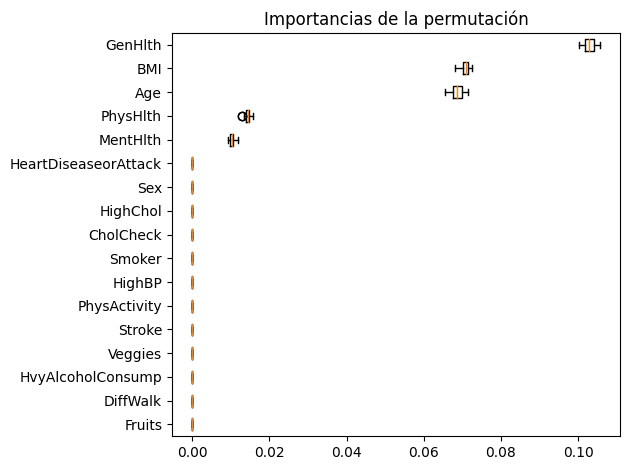

In [9]:
sorted_idx = res_pi.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    res_pi.importances[sorted_idx].T, vert= False , labels=X_train.columns[sorted_idx]
)
ax.set_title( "Importancias de la permutación" )
fig.tight_layout()
plt.show()

**Respuesta:**

Se mide la importancia de una característica calculando el aumento en el error de predicción del modelo después de permutar la característica. Por ejemplo se mantienen todas las columnas fijas, a excepción por la que se quiere estudiar ordenando de forma aleatoria sus elementos. Se considera una característica es "importante" si al mezclar sus valores aumenta el error del modelo. Por otro lado, se considera una característica es "sin importancia" si al mezclar sus valores deja no modifica el error del modelo.

Los 5 valores más importantes, fueron los que tienen una mayor posibilidad de valores, por lo que es mucho más probable que estas afecten de mayor manera al ordenarse al azar, ya que es más dificil mantener el valor original. En cambio en la variables binarias, es mucho más posible repetir los valores, y aun más cuando existen clases desbalanceadas como lo es en este caso.

En comparación al modelo anterior, este le da mayores importancias a aquellos valores que tienen una mayor gama de valores posibles, pero solo limitada a entender estos valores. En cambio la otra forma de análisis comprende ambas formas. De igual forma este método también deja visualizar como afectarían estas variables al modelo.

**Ventajas:**

- La medida de importancia tiene en cuenta automáticamente todas las interacciones con otras características. Por lo que es posible ver como interactuan las variables con el modelo.

- La importancia de la función de permutación no requiere volver a entrenar el modelo, ya que al metodo solo le importa la variación de respuesta frente a un mismo modelo.

- Tiene una fácil interpretabilidad, ya que al aumentar el error, es fácil darse cuenta cuales son las variables que afectan mayormente a la predicción.

**Desventajas:**

- Se necesita tener acceso a los valores reales de la clasificación, ya que de otra manera es imposible corroborar cuanto error es el que se le agrega al resultado.

- Depende demasiado de la aleatoridad. Si bien en este caso se trata de estabilizar el error asociado repitiendo el proceso 30 veces, aumenta demasiado el costo computacional.

- Cuando existen datos correlacionados y reales, puede generar situaciones improbables e inexistentes, los cual puede entorpecer aún más el análisis. Por ejemplo con esta aleatoreidad es posible que se cree un caso donde la altura de un individiu no corresponda con el peso (Caso extremo: 1.80m altura y 30 kg de peso).

[1] https://medium.com/the-modern-scientist/agnostic-explainable-artificial-intelligence-xai-f998309a0c09

[2] https://christophm.github.io/interpretable-ml-book/feature-importance.html

## 5. Métodos Agnósticos Locales (2 pt)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### Parte A (0.4 pt)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [10]:
!pip install shap

You should consider upgrading via the 'C:\Users\jos_5\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [11]:
import warnings
import shap
import pickle
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

c:\Users\jos_5\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\jos_5\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

In [12]:
# Se da por hecho y en su lugar se cargan los datos de pickle

# explainer = shap.Explainer(pipeline.predict, X_test)
# shap_values = explainer(X_test)

# # Guardar los valores SHAP en un archivo
# with open('shap_values.pkl', 'wb') as f:
#     pickle.dump(shap_values, f)

# Cargar los valores SHAP desde un archivo
with open('shap_values.pkl', 'rb') as f:
    shap_values = pickle.load(f)

Cada número en el resultado de los Shap values representa la contribución de una característica específica a la predicción del modelo para un ejemplo de entrada dado. Un valor positivo indica que la presencia o un valor más alto de esa característica aumenta la predicción del modelo, mientras que un valor negativo indica que la presencia o un valor más bajo de esa característica disminuye la predicción del modelo. El valor absoluto de un Shap value indica la importancia de la característica en la predicción.

### Parte B (0.4 pt)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?
- ¿Existe algún patrón común entre las instancias analizadas?
- ¿Es posible generalizar estas conclusiones a todo el dataset?

In [13]:
import numpy as np
import pandas as pd

instancias = [1, 9, 150]
columnas = ['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
            'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Stroke', 'HighBP']

data = []
for i in instancias:
    arreglo_instancia = shap_values[i].values.flatten().tolist()
    data.append([i] + arreglo_instancia)

db = pd.DataFrame(data, columns=['Instancia'] + columnas)
db


,Instancia,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP
0,1,0.228571,0.0,0.0,0.0,0.126429,0.0,0.0,0.0,0.0,0.0,0.0,0.099286,0.006429,0.009286,0.0,0.0,0.0
1,9,0.063214,0.0,0.0,0.0,-0.319286,0.0,0.0,0.0,0.0,0.0,0.0,-0.286071,0.006786,0.005357,0.0,0.0,0.0
2,150,0.196429,0.0,0.0,0.0,-0.213214,0.0,0.0,0.0,0.0,0.0,0.0,-0.341071,-0.038929,-0.133214,0.0,0.0,0.0


Aporte de variables - Instancia 1


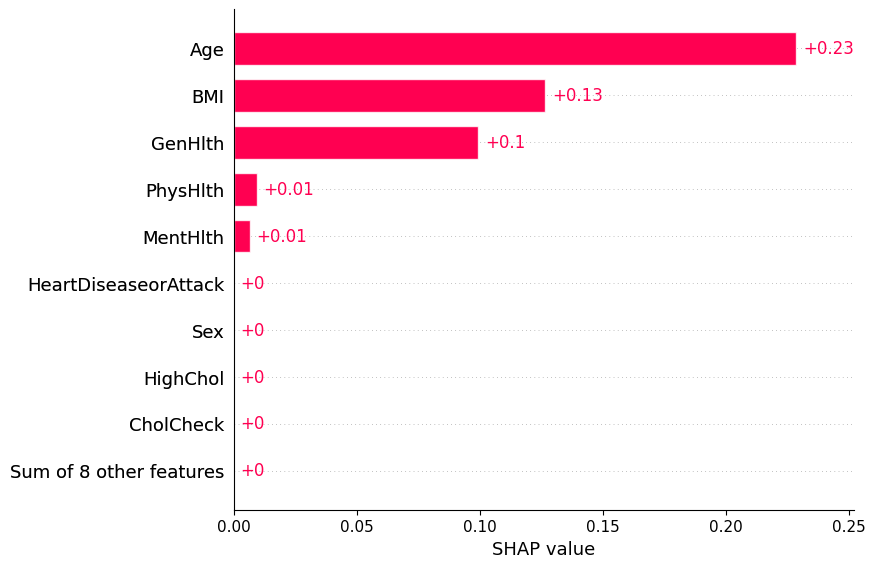

Aporte de variables - Instancia 9


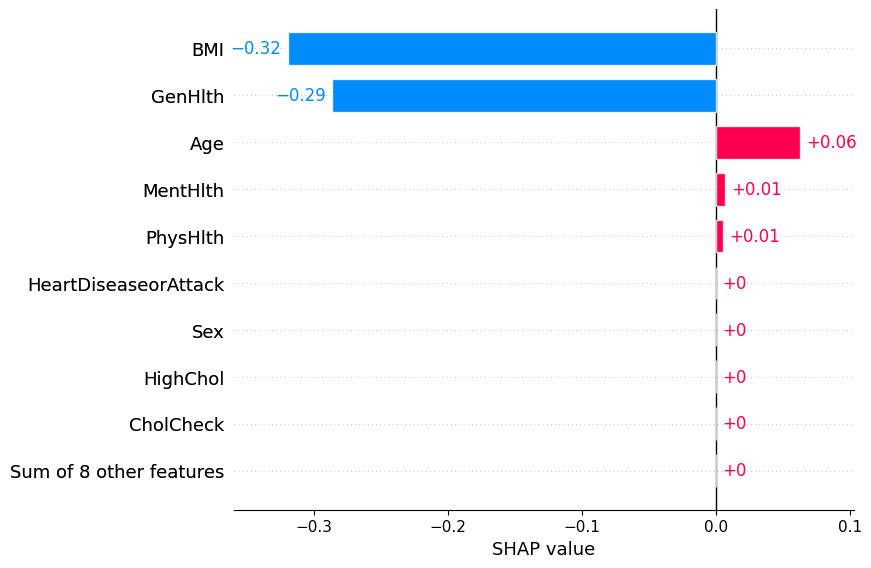

Aporte de variables - Instancia 150


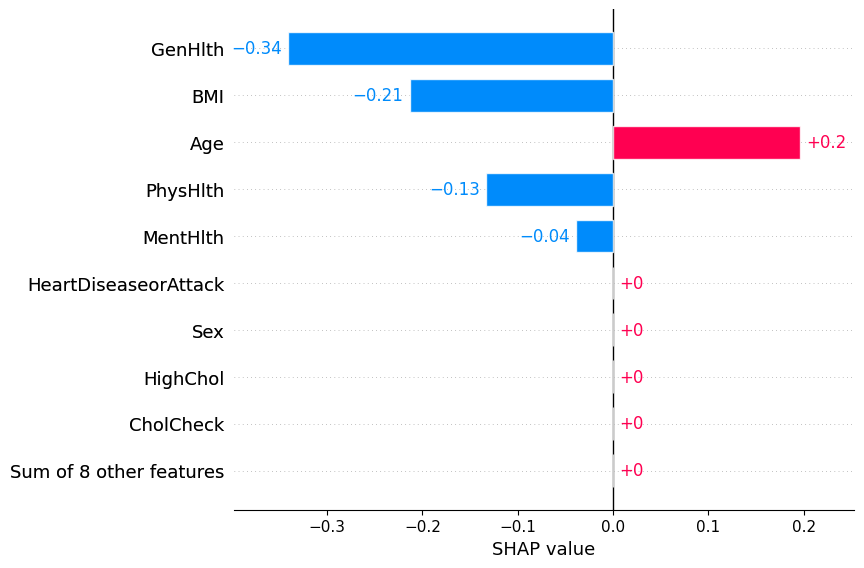

In [14]:
instancias = [1, 9, 150]

for i in instancias:
  print(f"Aporte de variables - Instancia {i}")
  shap.plots.bar(shap_values[i])

- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?
En la instancia 1, las variables que afectan positivamente la probabilidad de tener diabetes son Age (0.23), BMI (0.13), GenHlth (0.1), y MentHlth (0.01). En la instancia 2, Age (0.06), MentHlth (0.01), y PhysHlth (0.01) tienen un aporte positivo, mientras que BMI (-0.32), GenHlth (-0.29) tienen un impacto negativo en la probabilidad de diabetes. En la instancia 3, Age (0.2) afecta positivamente, mientras que GenHlth (-0.34), BMI (-0.21), MentHlth (-0.04), y PhysHlth (-0.13) tienen un aporte negativo a la probabilidad de tener diabetes.

- ¿Existe algún patrón común entre las instancias analizadas?
El patrón común entre las instancias analizadas es que la variable Age tiene un impacto positivo en la probabilidad de tener diabetes en todas las instancias. Además, la variable GenHlth muestra una influencia negativa en dos de las tres instancias. Las variables BMI, MentHlth y PhysHlth tienen un impacto variable en diferentes instancias, con aportes positivos en algunas y negativos en otras. 

- ¿Es posible generalizar estas conclusiones a todo el dataset?
Como se puede ver todas las demas variables no mencionadas tienen un aporte nulo tales alto colesterol, ataque de corazón lo cual es sospechoso ya médicamente hablando estos pueden ser factores de riesgo o consecuencias que podrían estar asociados a diabetes, por tanto dado que estamos analizando solo tres instancias, no podemos generalizar estas conclusiones a todo el dataset, pues pueden existir variables de las cuales no se este caturando su efecto. Es importante realizar un análisis más amplio y representativo del dataset para obtener conclusiones más sólidas y generalizables.

### Parte C (0.4 pt)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

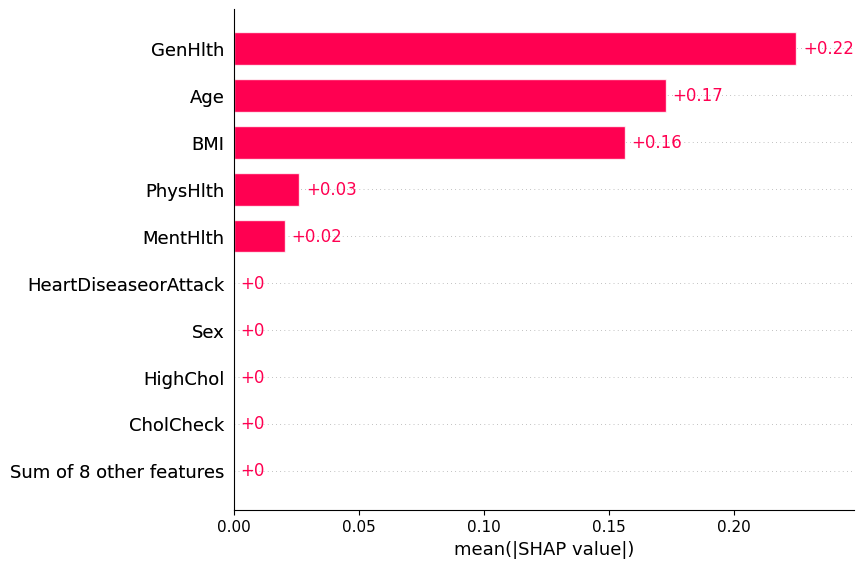

In [15]:
shap.plots.bar(shap_values)

Las conclusiones a nivel de instancia se centran en el impacto específico de las variables en cada caso individual, mientras que los mean shap values representan el impacto promedio de las variables en el conjunto de datos completo. A nivel de instancia, los shape values capturan el efecto individual de cada variable, mientras que los mean shap values consideran las interacciones entre las variables al calcular el impacto promedio. Para generalizar estos resultados al dataset completo, es necesario tener en cuenta tanto las conclusiones a nivel de instancia como las interacciones entre las variables.

Dado que el gráfico de los mean shap values de todas las variables proporciona información relevante sobre el impacto promedio de cada variable en el conjunto de datos completo, en los que se puede apreciar que solo 4 variables resultando en un aporte no nulo en la diabetes tal cual se tenia en el análisis de instancias, se puede generalizar el efecto de estas variables en la probabilidad de tener diabetes para todo el dataset.

Sin embargo, es importante tener en cuenta que los mean shap values representan una medida promedio y no capturan necesariamente las variaciones individuales. Puede haber casos específicos dentro del dataset donde algunas variables tengan un impacto diferente al promedio.

### Parte D (0.4 pt)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

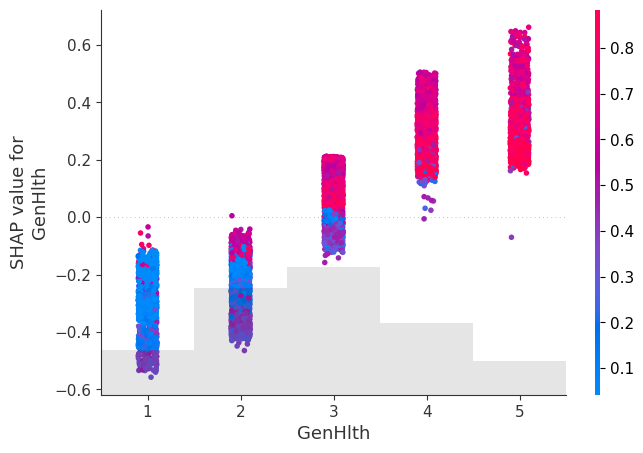

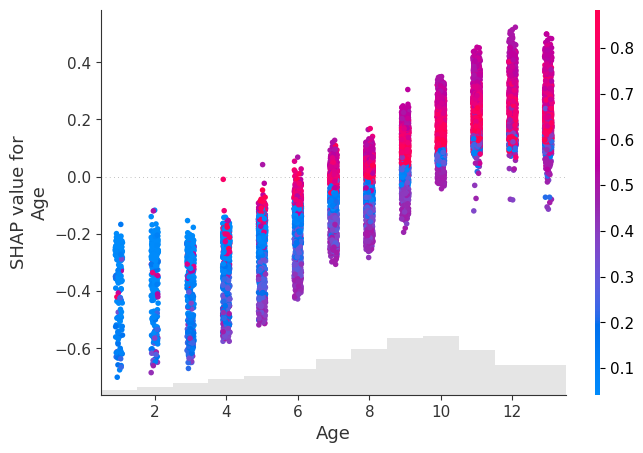

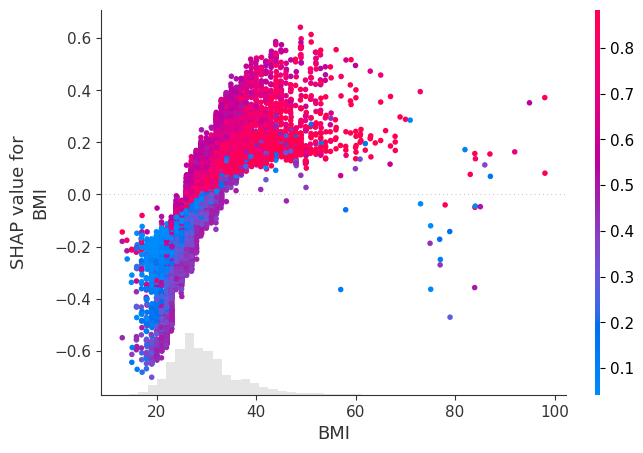

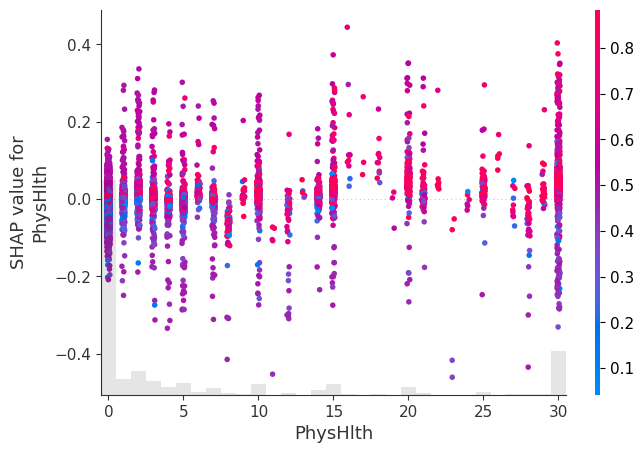

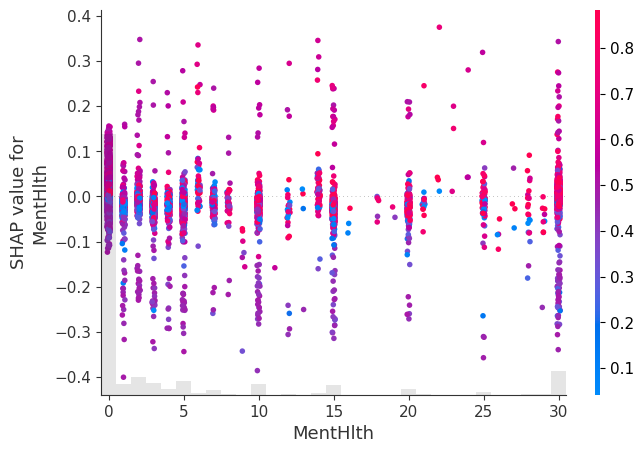

In [16]:
probabilities = pipeline.predict_proba(X_test)[:, 1]

shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]

for name in feature_importance_names[:5]:
    shap.plots.scatter(shap_values[:,name], 
                   color=probabilities) 

Existe una relación clara entre los Shap values y la probabilidad de tener diabetes. En general, los puntos con Shap values más altos tienden a tener una mayor probabilidad de tener diabetes, mientras que los puntos con Shap values más bajos tienen una menor probabilidad.

Las características con mayor impacto global en la predicción de la probabilidad de tener diabetes son consistentes con las conclusiones anteriores. Las primeras 5 características con mayor impacto son aquellas que tienen una mayor dispersión en los Shap values y tienen una influencia significativa en la probabilidad. Por ejemplo se puede ver que en general mayores BMI implican mayor Shape Value y además casi todas las muestras para ese nivel de BMI induce una muy alta probabilidad de diabetes, lo mismo sucede con la edad y el GenHlth, en general una edad y mayor nivel en GenHlth (se asume que un mayor nivel seria un menor estado de salud en general) involucra un alto shape value y una alta probabilidad, por otro lado las 2 variables restantes con mayor impacto global como MentHlth y PhysHlth son mas variables en cada nivel de estas variables existen muestras tanto con alto y bajo shape value que tienen una alta probabilidad de cancer (puntos rojos) pero se puede notar para la variable PyhsHlth que en general en torno a un valor de +/- 0.2 en shape value son los puntos con alta probabilidad de cancer (más rojos) y lo mismo sucede para MentHlth pero entre un shape value de +/- 0.1.
 


### Parte E (0.4 pt)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

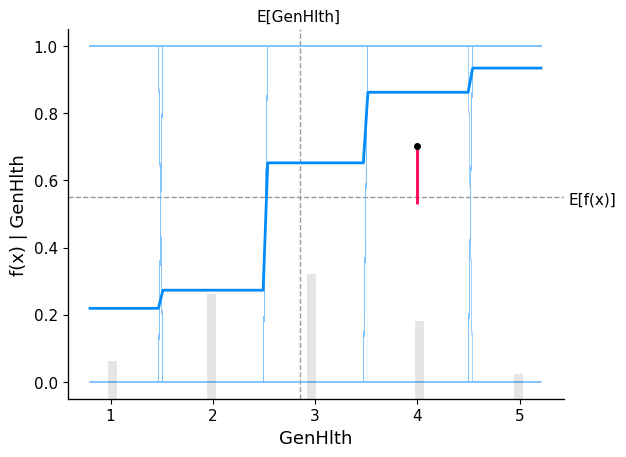

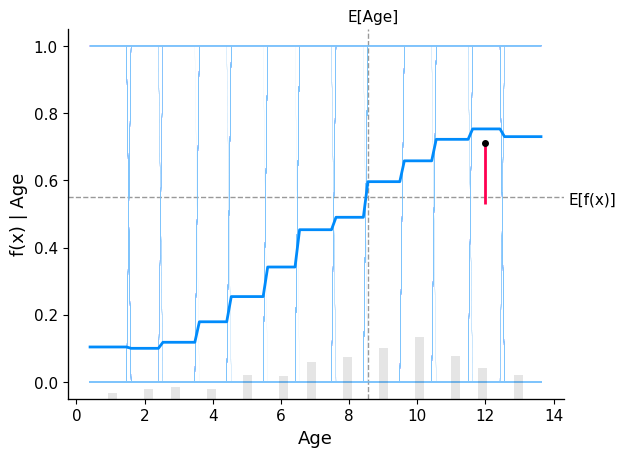

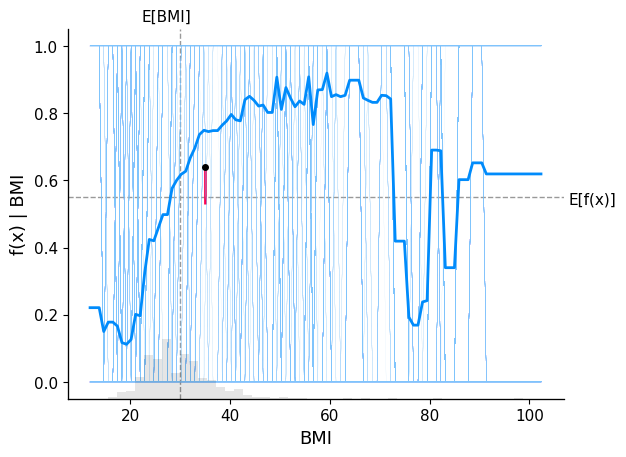

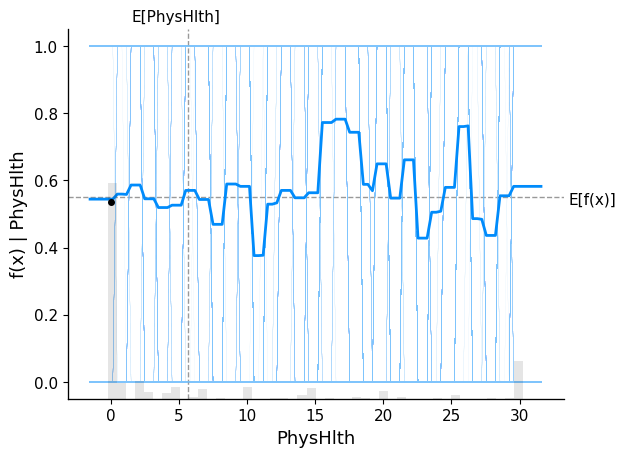

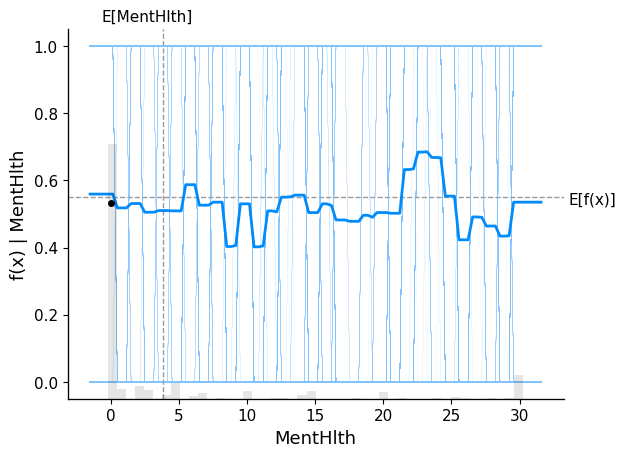

In [17]:
X100 = shap.utils.sample(X, 1000)
sample_ind = 20
for name in feature_importance_names[:5]:
    shap.partial_dependence_plot(
        name, pipeline.predict, X100, model_expected_value=True,
        feature_expected_value=True, ice=True,
        shap_values=shap_values[sample_ind:sample_ind+1,:]
    )


En el caso de la submuestra de 1000 datos, se puede observar que la relación entre la salida promedio del modelo y cada característica analizada varía.

Para la variable "Age" (edad), se aprecia que a medida que aumenta la edad, la probabilidad de tener diabetes también tiende a aumentar. Esto sugiere una relación positiva entre la edad y la salida promedio del modelo.

En cuanto a la variable "GenHlth" (salud general), se observa que a medida que el valor de GenHlth aumenta (lo que indica una mejor salud general), la probabilidad de tener diabetes tiende a disminuir. Esto indica una relación negativa entre GenHlth y la salida promedio del modelo.

Sin embargo, para las otras tres características analizadas, el comportamiento es más ruidoso y no se observa una tendencia clara. En estos casos, se puede notar que la probabilidad de tener diabetes varía en ciertos rangos de valores de las características, pero no se puede establecer una relación lineal directa con la salida promedio del modelo.

Es importante tener en cuenta que estas conclusiones se basan en la submuestra de 1000 datos y pueden no ser generalizables para todo el conjunto de datos. Para obtener conclusiones más robustas y generalizables, se recomienda realizar un análisis estadístico más completo y considerar todo el conjunto de datos disponible.

## 6. Sistema de Reglas! (1 pt)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [18]:
!pip install alibi

You should consider upgrading via the 'C:\Users\jos_5\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [19]:
from alibi.explainers import AnchorTabular

In [20]:
# Obtener el índice de la observación que deseas explicar
idx_1 = 1000
idx_2 = 3001
idx_3 = 5751

# Obtener el modelo del pipeline
model = pipeline.named_steps['model']

# Obtener los nombres de las características del preprocesador
preprocessor = pipeline.named_steps['preprocessor']
test_feature_names = X_test.columns.tolist()

# Asegurarse de que las características en observation coincidan con las características esperadas por el modelo y el explainer

# Observación 1 (índice 1000)
observation_1 = X_test.iloc[[idx_1]]  # Obtener la fila correspondiente al índice
observation_1 = preprocessor.transform(observation_1)

# Observación 2 (índice 3001)
observation_2 = X_test.iloc[[idx_2]]  # Obtener la fila correspondiente al índice
observation_2 = preprocessor.transform(observation_2)

# Observación 3 (índice 5751)
observation_3 = X_test.iloc[[idx_3]]  # Obtener la fila correspondiente al índice
observation_3 = preprocessor.transform(observation_3)

# Obtener los nombres de las características transformadas
feature_names = preprocessor.get_feature_names_out(input_features=test_feature_names)

# Crear la función de predicción utilizando el modelo
predict_fn = lambda x: model.predict(x)

# Crear el explainer utilizando AnchorTabular
explainer = AnchorTabular(predict_fn, feature_names=feature_names, seed=42)
explainer.fit(preprocessor.transform(X))  # Aplicar preprocesamiento a los datos de entrenamiento
class_names = ["No_diabetico", "Diabetico"]

# Explicar la predicción en el índice 1000
explanation_1 = explainer.explain(observation_1, threshold=0.95)

# Explicar la predicción en el índice 3001
explanation_2 = explainer.explain(observation_2, threshold=0.95)

# Explicar la predicción en el índice 5751
explanation_3 = explainer.explain(observation_3, threshold=0.95)

# Imprimir los resultados

# Observación 1
print('Observación 1:')
print('Predicción: ', class_names[explainer.predictor(observation_1)[0]])
print('Anchor: %s' % (' AND '.join(explanation_1.anchor)))
print('Precisión: %.2f' % explanation_1.precision)
print('Cobertura: %.2f' % explanation_1.coverage)
print()

# Observación 2
print('Observación 2:')
print('Predicción: ', class_names[explainer.predictor(observation_2)[0]])
print('Anchor: %s' % (' AND '.join(explanation_2.anchor)))
print('Precisión: %.2f' % explanation_2.precision)
print('Cobertura: %.2f' % explanation_2.coverage)
print()

# Observación 3
print('Observación 3:')
print('Predicción: ', class_names[explainer.predictor(observation_3)[0]])
print('Anchor: %s' % (' AND '.join(explanation_3.anchor)))
print('Precisión: %.2f' % explanation_3.precision)
print('Cobertura: %.2f' % explanation_3.coverage)


Could not find an anchor satisfying the 0.95 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.
Could not find an anchor satisfying the 0.95 precision constraint. Now returning the best non-eligible result. The desired precision threshold might not be achieved due to the quantile-based discretisation of the numerical features. The resolution of the bins may be too large to find an anchor of required precision. Consider increasing the number of bins in `disc_perc`, but note that for some numerical distribution (e.g. skewed distribution) it may not help.


Observación 1:
Predicción:  Diabetico
Anchor: escala_estandar__Age > 0.85 AND escala_estandar__BMI > -0.69
Precisión: 0.88
Cobertura: 0.10

Observación 2:
Predicción:  Diabetico
Anchor: escala_estandar__GenHlth > -0.75 AND escala_estandar__BMI > 0.44
Precisión: 0.94
Cobertura: 0.19

Observación 3:
Predicción:  No_diabetico
Anchor: escala_estandar__GenHlth <= -0.75 AND escala_estandar__BMI <= -0.69
Precisión: 0.99
Cobertura: 0.14


Para el entrenamiento del explainer se decidio aplicar el preprocesamiento de escalado, asi nos aseguramos de que las variables estén en la misma escala para el train set y el set del explainer. Esto es importante porque el explainer interpreta el modelo entrenado y, si las variables no están en la misma escala, las importancias de las características y las reglas generadas por el explainer pueden no ser precisas o interpretarse incorrectamente, dicho esto se obtuvieron los siguientes resultados:

Observación 1:
La regla propuesta es "escala_estandar__Age > 0.85 AND escala_estandar__BMI > -0.69". Esto indica que si la edad está por encima de 0.85 en la escala estandarizada y el índice de masa corporal (BMI) está por encima de -0.69 en la escala estandarizada, la predicción será "Diabetico". La precisión de esta regla es del 0.88, lo que significa que el 88% de los ejemplos que cumplen con esta regla son realmente casos de diabetes. Sin embargo, la cobertura es baja (0.10), lo que indica que solo el 10% de los ejemplos en el conjunto de datos cumplen con esta regla.

Observación 2:
La regla propuesta es "escala_estandar__GenHlth > -0.75 AND escala_estandar__BMI > 0.44". Esto significa que si la salud general (GenHlth) está por encima de -0.75 en la escala estandarizada y el BMI está por encima de 0.44 en la escala estandarizada, la predicción será "Diabetico". La precisión de esta regla es del 0.94, lo que indica que el 94% de los ejemplos que cumplen con esta regla son realmente casos de diabetes. Sin embargo, la cobertura es nuevamente baja (0.19), lo que implica que solo el 19% de los ejemplos en el conjunto de datos cumplen con esta regla.

Observación 3:
La regla propuesta es "escala_estandar__GenHlth <= -0.75 AND escala_estandar__BMI <= -0.69". Esto indica que si la salud general está por debajo o igual a -0.75 en la escala estandarizada y el BMI está por debajo o igual a -0.69 en la escala estandarizada, la predicción será "No_diabetico". La precisión de esta regla es alta (0.99), lo que significa que el 99% de los ejemplos que cumplen con esta regla son realmente casos de no diabetes. Sin embargo, al igual que las reglas anteriores, la cobertura es baja (0.14), lo que implica que solo el 14% de los ejemplos en el conjunto de datos cumplen con esta regla.

En cuanto a la cobertura y precisión en general, observamos que las reglas propuestas tienen una cobertura baja, lo que significa que solo explican una pequeña fracción de la población total. Por otro lado, la precisión varía, pero en ningún caso alcanza el umbral del 0.95 deseado. Esto indica que las reglas no son lo suficientemente precisas para ser aplicadas de manera confiable en todo el conjunto de datos.

En cuanto al sentido de las reglas propuestas, se puede argumentar que tienen un sentido lógico y parecen capturar ciertas correlaciones entre las características y la predicción de la diabetes. Sin embargo, debido a la baja cobertura y la falta de precisión suficiente, estas reglas no pueden considerarse como reglas generales y aplicables a todo el conjunto de datos.

# Retrospectiva... (1 pt)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

Para este problema de clasificación de diabetes, los métodos que permiten entregar mejores conclusiones son:

Análisis de instancias y Shapley values: Estos métodos proporcionan información detallada sobre el impacto individual de cada característica en la predicción de cada instancia. Por ejemplo, se encontró que la edad (Age) y el índice de masa corporal (BMI) tienen un impacto significativo en la predicción de diabetes. A medida que aumenta la edad, la probabilidad de tener diabetes tiende a aumentar, mientras que un mayor valor de BMI también está asociado con un mayor riesgo de diabetes.

Análisis de importancia de características: Se utilizó la importancia de características basada en el modelo de XGBoost para identificar las variables más relevantes para la clasificación de diabetes. Se encontró que las características más importantes fueron Age, BMI, GenHlth. Estas variables tienen un mayor impacto en el modelo y son útiles para tomar decisiones en la clasificación de diabetes.

En cuanto al problema del Dr. Simi, los métodos más útiles son los métodos agnósticos locales. Estos métodos permiten explicar las decisiones del modelo a nivel individual y generar reglas comprensibles para los clientes. En este caso, se utilizó el explainer AnchorTabular para generar reglas explicativas. Por ejemplo, se encontró que para una observación específica, si la edad está por encima de 0.85 en la escala estandarizada y el BMI está por encima de -0.69 en la escala estandarizada, la predicción será "Diabético". Estas reglas son más aplicables y comprensibles para los clientes del Dr. Simi, ya que permite entender el razonamiento detrás de las predicciones y tomar decisiones informadas sobre su tratamiento y cuidado de la diabetes (aunque teniendo en cuenta que solo son aplicables a un bajo nivel de muestras y no ha todas)

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>